In [1]:
#imports 
import os
from collections import Counter
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T
import torch.nn as nn
import torch.optim as optim

from PIL import Image

import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
from nltk.corpus import stopwords

from torchvision.models import resnet50, ResNet50_Weights
import torch
import datetime

import sys
sys.path.append('../src')
from utils import Vocabulary, FlickrDataset, CapsCollate, show_image, EncoderDecoder, DecoderRNN
from pylab import rcParams

image_path = "../all_images/Flicker8k_Dataset/" 
train_file_path = '../all_captions/Flickr_8k.trainImages.txt'
captions_path = "../all_captions/Flickr8k.token.txt"
test_file_path = '../all_captions/Flickr_8k.testImages.txt'
run = datetime.datetime.now().strftime('%b-%d-%H-%M-%S')
MODEL_SAVE_PATH = '../models/resnet-50-' + run + '.pth'
TRACKING_DICT_PATH = '../models/tracking-' + run + '.csv'

c:\Users\bruno\anaconda3\envs\edap5\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# TODO:

- Check vocabulary size (paper has 10k words)
- Check bleu input if it is in format [['awd', 'awd'], [etc]]

In [2]:
from ignite.metrics.nlp import Bleu

m = Bleu(ngram=4, smooth="smooth1")

y_pred = "a cat is seen on a"
y = ["the cat is on the mat", "there is a cat on the mat"]

m.update(([y_pred.split()], [[_y.split() for _y in y]]))

print(m.compute())

tensor(0.1221, dtype=torch.float64)


In [3]:
def clean_text(text):
  text = text.lower()
  text = re.sub("[^a-z]+", " ", text)
  text = text.split()
  text = [s for s in text if len(s)> 1]
  text = " ".join(text)
  return text

caption_file = open(captions_path, "r").read()

BATCH_SIZE = 256
NUM_WORKERS = 0
frequency_threshold = 1

transform = T.Compose([
                T.Resize(256),
                T.CenterCrop(224),
                T.ToTensor(),
                T.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]
            )])

toTensor = T.Compose([
                T.Resize(256),
                T.CenterCrop(224),
                T.ToTensor()])

keys = []
caption_list = []

for row in caption_file.split("\n"):
    key = row.split("#")[0].split(".")[0]
    caption = row.split("#")[-1].split("\t")[-1]
    caption = caption.replace('.', '')
    caption = clean_text(caption)

    keys.append(key)
    caption_list.append(caption)

captions = pd.DataFrame(data=zip(keys, caption_list), columns=["image", "caption"])

train_file = open(train_file_path, 'r').read()
train_imgs = [row.split(".")[0] for row in train_file.split("\n")[:-1]]
train_data = captions[captions.image.isin(train_imgs)]
train_data = train_data.reset_index()

test_file = open(test_file_path, 'r').read()
test_imgs = [row.split(".")[0] for row in test_file.split("\n")[:-1]]
test_data = captions[captions.image.isin(test_imgs)]
test_data = test_data.reset_index()

vocab = Vocabulary(frequency_threshold)
vocab.build_vocab(captions.caption.tolist())

train_dataset = FlickrDataset("../all_images/Flicker8k_Dataset", train_data, transform=transform, vocab=vocab)
test_dataset = FlickrDataset("../all_images/Flicker8k_Dataset", test_data, transform=toTensor, vocab=vocab)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, collate_fn=CapsCollate)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, collate_fn=CapsCollate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
embed_size = 300
vocab_size = len(vocab)
attention_dim = 128
encoder_dim = 2048
decoder_dim = 256

model = EncoderDecoder(embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim, device)
model.load_state_dict(torch.load("../models/resnet-50-Feb-20-17-02-19.pth"))
model.eval()
model.to(device)

c:\Users\bruno\anaconda3\envs\edap5\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\bruno\anaconda3\envs\edap5\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EncoderDecoder(
  (encoder): EncoderCNN(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
 

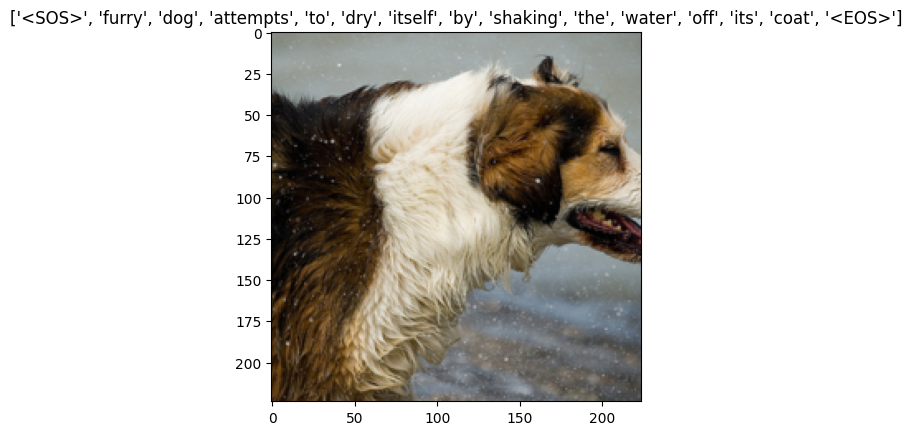

In [5]:
show_image(test_dataset[42][0], [test_dataset.vocab.itos[int(i.numpy())] for i in test_dataset[42][1]])

In [6]:
features = model.encoder(test_dataset[42][0].unsqueeze(0).to(device))
caption, alphas = model.decoder.generate_caption(features, 40, vocab=test_dataset.vocab)

In [7]:
len(alphas), caption

(7, ['dog', 'is', 'running', 'through', 'the', 'water', '<EOS>'])

In [8]:
test_dataset[42][0].shape

torch.Size([3, 224, 224])

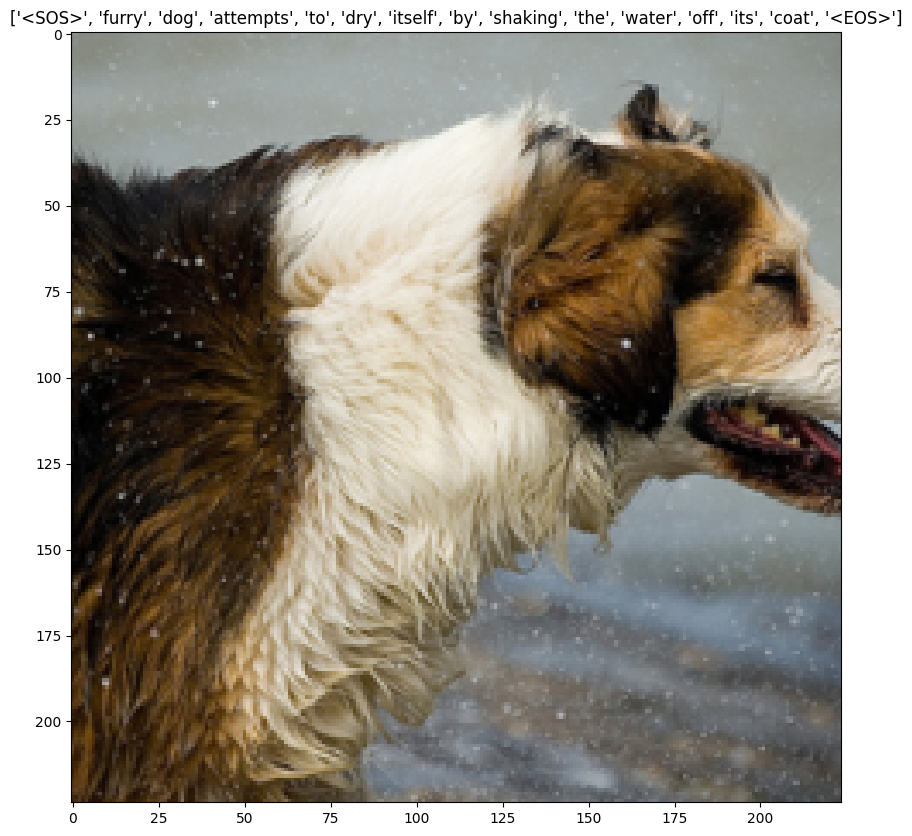

In [9]:
rcParams['figure.figsize'] = 10, 10
show_image(test_dataset[42][0], [test_dataset.vocab.itos[int(i.numpy())] for i in test_dataset[42][1]])

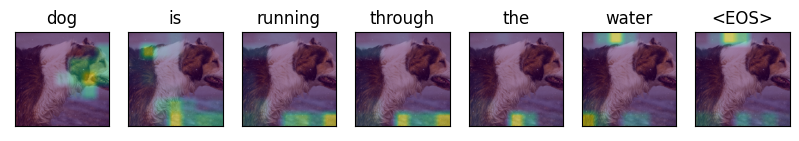

Original Caption:  <SOS> furry dog attempts to dry itself by shaking the water off its coat <EOS>


In [10]:
features = model.encoder(test_dataset[42][0].unsqueeze(0).to(device))
caption, alphas = model.decoder.generate_caption(features, 40, vocab=test_dataset.vocab)
n_filters, ix = len(alphas), 1
for i in range(len(alphas)):
    f = T.Resize((224,224))(torch.from_numpy(alphas[i].reshape((14, 14))).unsqueeze(0)).squeeze(0)
    ax = plt.subplot(1, n_filters, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(test_dataset[42][0].numpy().transpose((1,2,0)))
    plt.imshow(f, alpha = 0.5)
    plt.title(caption[i])
    ix += 1

rcParams['figure.figsize'] = 20, 40
plt.show()

print("Original Caption: ", " ".join([test_dataset.vocab.itos[int(i.numpy())] for i in test_dataset[42][1]]))

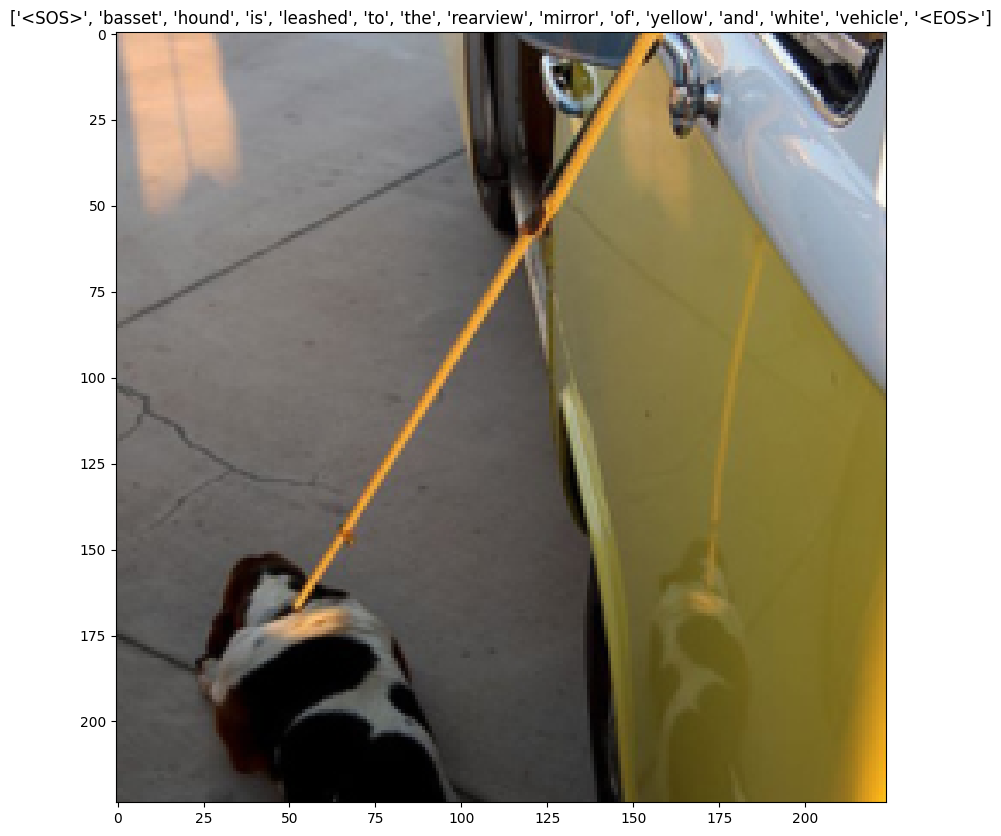

In [11]:
rcParams['figure.figsize'] = 10, 10
show_image(test_dataset[420][0], [test_dataset.vocab.itos[int(i.numpy())] for i in test_dataset[420][1]])

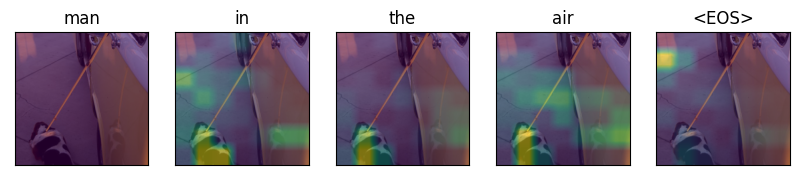

Original Caption:  <SOS> basset hound is leashed to the rearview mirror of yellow and white vehicle <EOS>


In [12]:
features = model.encoder(test_dataset[420][0].unsqueeze(0).to(device))
caption, alphas = model.decoder.generate_caption(features, 40, vocab=test_dataset.vocab)
n_filters, ix = len(alphas), 1
for i in range(len(alphas)):
    f = T.Resize((224,224))(torch.from_numpy(alphas[i].reshape((14, 14))).unsqueeze(0)).squeeze(0)
    ax = plt.subplot(1, n_filters, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(test_dataset[420][0].numpy().transpose((1,2,0)))
    plt.imshow(f, alpha = 0.5)
    plt.title(caption[i])
    ix += 1

rcParams['figure.figsize'] = 30, 30
plt.show()

print("Original Caption: ", " ".join([test_dataset.vocab.itos[int(i.numpy())] for i in test_dataset[420][1]]))

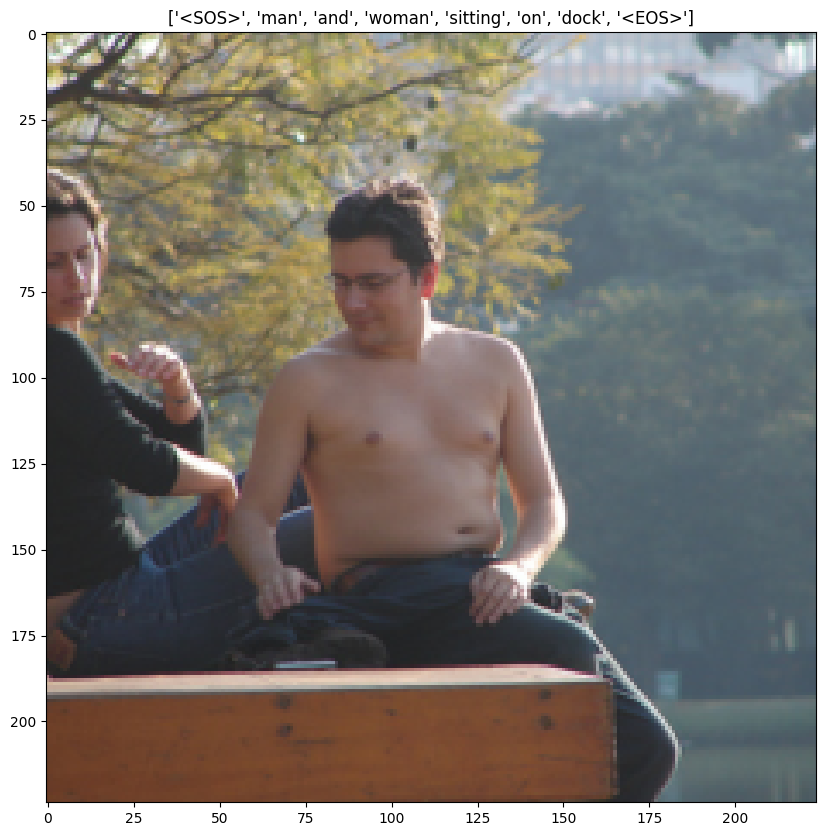

In [13]:
rcParams['figure.figsize'] = 10, 10
show_image(test_dataset[12][0], [test_dataset.vocab.itos[int(i.numpy())] for i in test_dataset[12][1]])

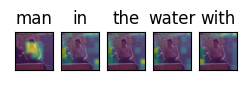

Original Caption:  <SOS> man and woman sitting on dock <EOS>
Generated Caption:  man in the water with his head is standing in the water with his arms out <EOS>


In [14]:
features = model.encoder(test_dataset[12][0].unsqueeze(0).to(device))
caption, alphas = model.decoder.generate_caption(features, 40, vocab=test_dataset.vocab)
n_filters, ix = len(alphas), 1
for i in range(len(alphas) - 12):
    f = T.Resize((224,224))(torch.from_numpy(alphas[i].reshape((14, 14))).unsqueeze(0)).squeeze(0)
    ax = plt.subplot(1, n_filters, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(test_dataset[12][0].numpy().transpose((1,2,0)))
    plt.imshow(f, alpha = 0.5)
    plt.title(caption[i])
    ix += 1

rcParams['figure.figsize'] = 100, 10
plt.show()

print("Original Caption: ", " ".join([test_dataset.vocab.itos[int(i.numpy())] for i in test_dataset[12][1]]))
print("Generated Caption: ", " ".join(caption))

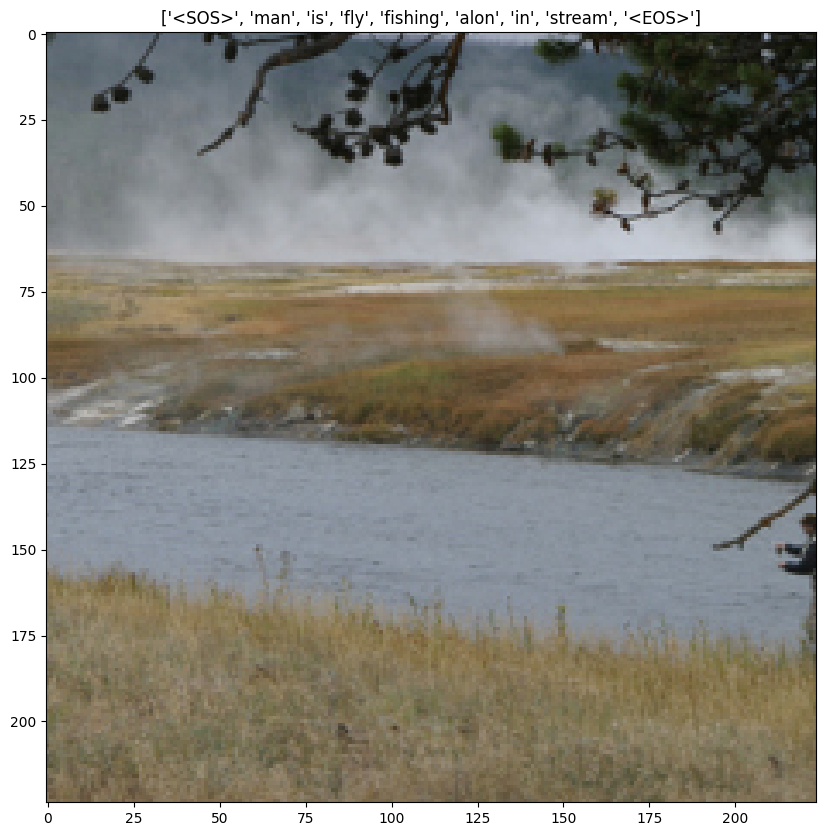

In [63]:
rcParams['figure.figsize'] = 10, 10
show_image(test_dataset[1230][0], [test_dataset.vocab.itos[int(i.numpy())] for i in test_dataset[1230][1]])

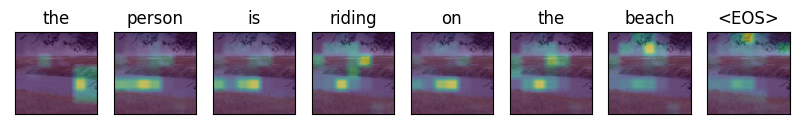

Original Caption:  <SOS> man is fly fishing alon in stream <EOS>
Generated Caption:  the person is riding on the beach <EOS>


In [16]:
features = model.encoder(test_dataset[1230][0].unsqueeze(0).to(device))
caption, alphas = model.decoder.generate_caption(features, 40, vocab=test_dataset.vocab)
n_filters, ix = len(alphas), 1
for i in range(len(alphas)):
    f = T.Resize((224,224))(torch.from_numpy(alphas[i].reshape((14, 14))).unsqueeze(0)).squeeze(0)
    ax = plt.subplot(1, n_filters, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(test_dataset[1230][0].numpy().transpose((1,2,0)))
    plt.imshow(f, alpha = 0.5)
    plt.title(caption[i])
    ix += 1

rcParams['figure.figsize'] = 100, 10
plt.show()

print("Original Caption: ", " ".join([test_dataset.vocab.itos[int(i.numpy())] for i in test_dataset[1230][1]]))
print("Generated Caption: ", " ".join(caption))

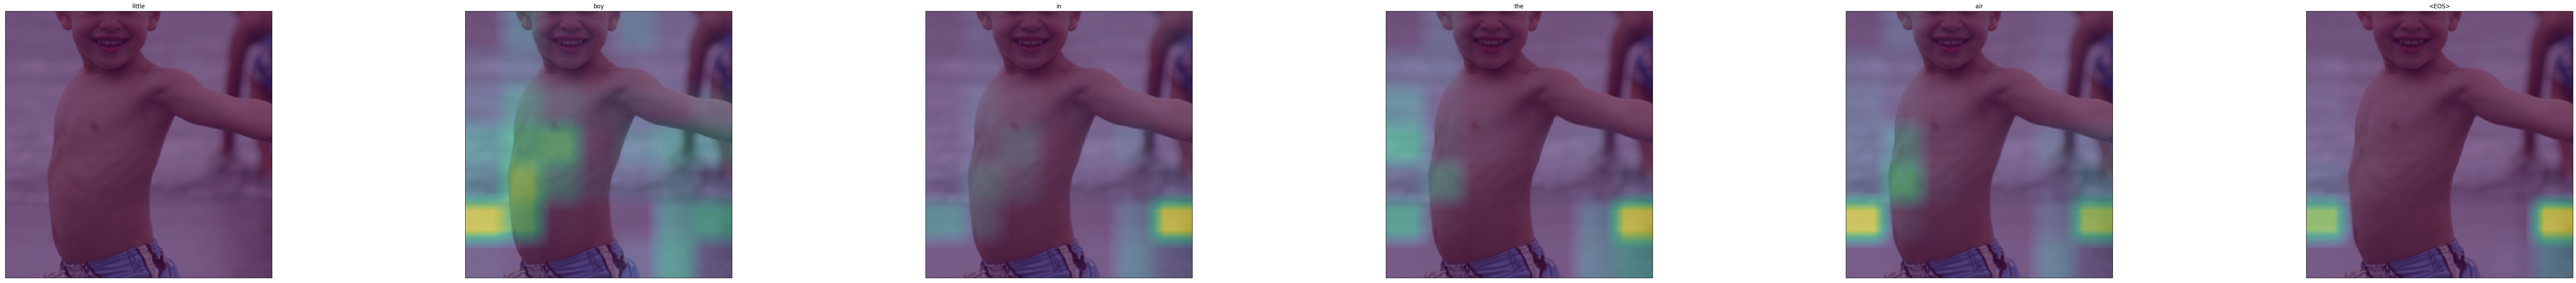

Original Caption:  <SOS> boy in his blue swim shorts at the beach <EOS>
Generated Caption:  little boy in the air <EOS>


In [167]:
features = model.encoder(test_dataset[5][0].unsqueeze(0).to(device))
caption, alphas = model.decoder.generate_caption(features, 40, vocab=test_dataset.vocab)
n_filters, ix = len(alphas), 1
for i in range(len(alphas)):
    f = T.Resize((224,224))(torch.from_numpy(alphas[i].reshape((14, 14))).unsqueeze(0)).squeeze(0)
    ax = plt.subplot(1, n_filters, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(test_dataset[5][0].numpy().transpose((1,2,0)))
    plt.imshow(f, alpha = 0.5)
    plt.title(caption[i])
    ix += 1

rcParams['figure.figsize'] = 100, 10
plt.show()

print("Original Caption: ", " ".join([test_dataset.vocab.itos[int(i.numpy())] for i in test_dataset[5][1]]))
print("Generated Caption: ", " ".join(caption))

## Using bilinear interpolation yields same result as just reshaping and resizing

torch.Size([1, 14, 14, 1])
torch.Size([224, 224])
torch.Size([1, 14, 14, 1])
torch.Size([224, 224])
torch.Size([1, 14, 14, 1])
torch.Size([224, 224])
torch.Size([1, 14, 14, 1])
torch.Size([224, 224])
torch.Size([1, 14, 14, 1])
torch.Size([224, 224])
torch.Size([1, 14, 14, 1])
torch.Size([224, 224])


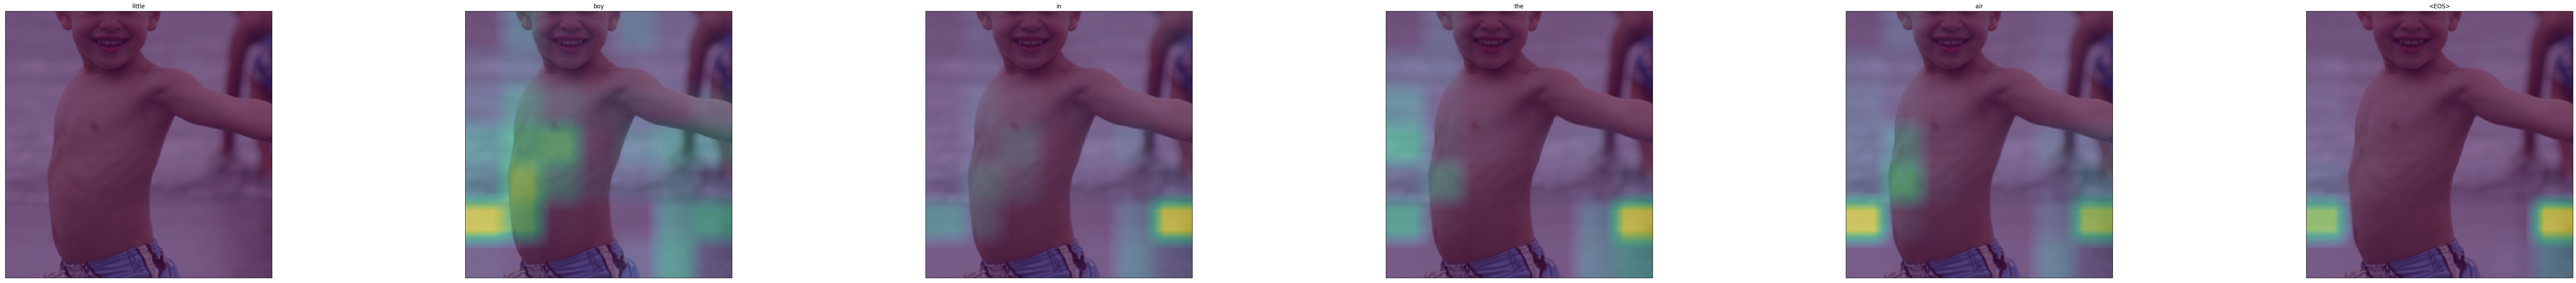

Original Caption:  <SOS> boy in his blue swim shorts at the beach <EOS>
Generated Caption:  little boy in the air <EOS>


In [168]:
features = model.encoder(test_dataset[5][0].unsqueeze(0).to(device))
caption, alphas = model.decoder.generate_caption(features, 40, vocab=test_dataset.vocab)
n_filters, ix = len(alphas), 1
for i in range(len(alphas)):
    f = torch.nn.functional.interpolate(torch.from_numpy(alphas[i].reshape((14, 14))).unsqueeze(0).unsqueeze(0), size = (224), mode="bilinear").squeeze(0).squeeze(0)
    ax = plt.subplot(1, n_filters, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(test_dataset[5][0].numpy().transpose((1,2,0)))
    plt.imshow(f, alpha = 0.5)
    plt.title(caption[i])
    ix += 1

rcParams['figure.figsize'] = 100, 10
plt.show()

print("Original Caption: ", " ".join([test_dataset.vocab.itos[int(i.numpy())] for i in test_dataset[5][1]]))
print("Generated Caption: ", " ".join(caption))

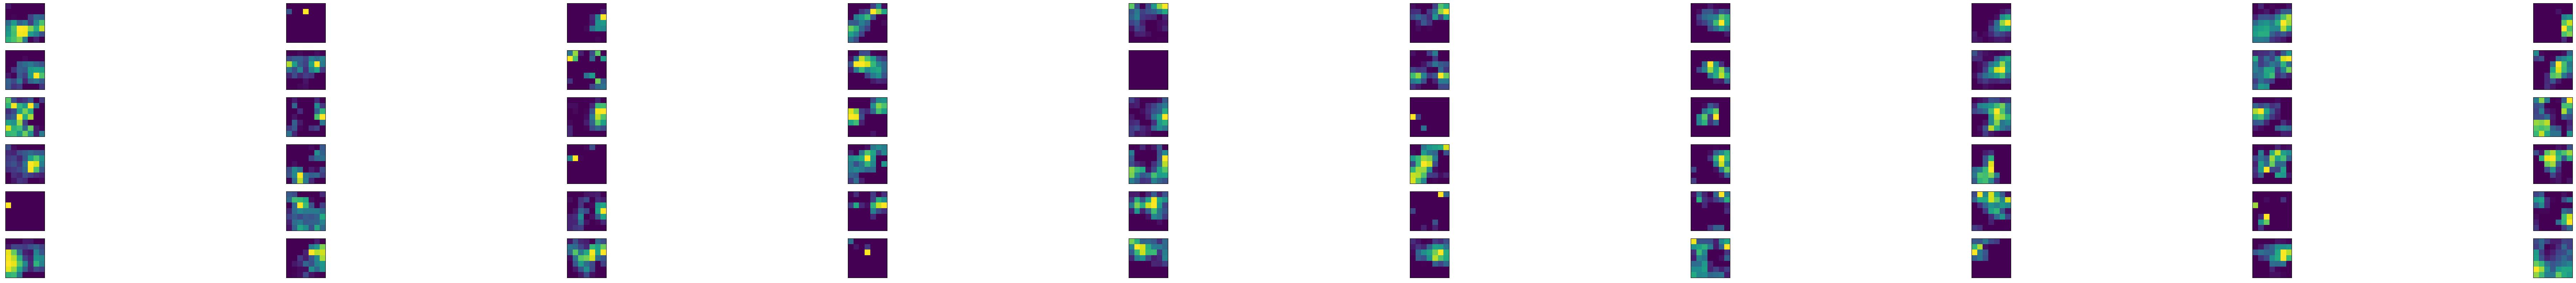

In [18]:
filters = model.encoder.resnet(test_dataset[42][0].unsqueeze(0).to(device))[0, :, :, :].cpu().numpy().transpose((0,1,2))

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
n_filters, ix = 6, 1
for i in range(n_filters):
    for j in range(10):
        # get the filter
        f = filters[ix-1, :, :]
        ax = plt.subplot(n_filters, 10, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(f[:, :])
        ix += 1
        
rcParams['figure.figsize'] = 100, 10
plt.show()

In [19]:
train_data

,index,image,caption
0,0,1000268201_693b08cb0e,child in pink dress is climbing up set of stai...
1,1,1000268201_693b08cb0e,girl going into wooden building
2,2,1000268201_693b08cb0e,little girl climbing into wooden playhouse
3,3,1000268201_693b08cb0e,little girl climbing the stairs to her playhouse
4,4,1000268201_693b08cb0e,little girl in pink dress going into wooden cabin
...,...,...,...
29995,40450,997338199_7343367d7f,person stands near golden walls
29996,40451,997338199_7343367d7f,woman behind scrolled wall is writing
29997,40452,997338199_7343367d7f,woman standing near decorated wall writes
29998,40453,997338199_7343367d7f,the walls are covered in gold and patterns


In [20]:
train_dog_counter = len(train_data[train_data["caption"].str.contains("[Dd]og")])
test_dog_counter = len(test_data[test_data["caption"].str.contains("[Dd]og")])

In [21]:
print(train_dog_counter)
print(test_dog_counter)
print("percentage of dog in train data: ", train_dog_counter/len(train_data))
print("percentage of dog in test data: ", test_dog_counter/len(test_data))

7153
1120
percentage of dog in train data:  0.23843333333333333
percentage of dog in test data:  0.224


In [55]:
test_dataset.captions[0:8]

0    blond woman in blue shirt appears to wait for ...
1            blond woman is on the street hailing taxi
2    woman is signaling is to traffic as seen from ...
3    woman with blonde hair wearing blue tube top i...
4    the woman in the blue dress is holding out her...
5             boy in his blue swim shorts at the beach
6                   boy smiles for the camera at beach
7    young boy in swimming trunks is walking with h...
Name: caption, dtype: object

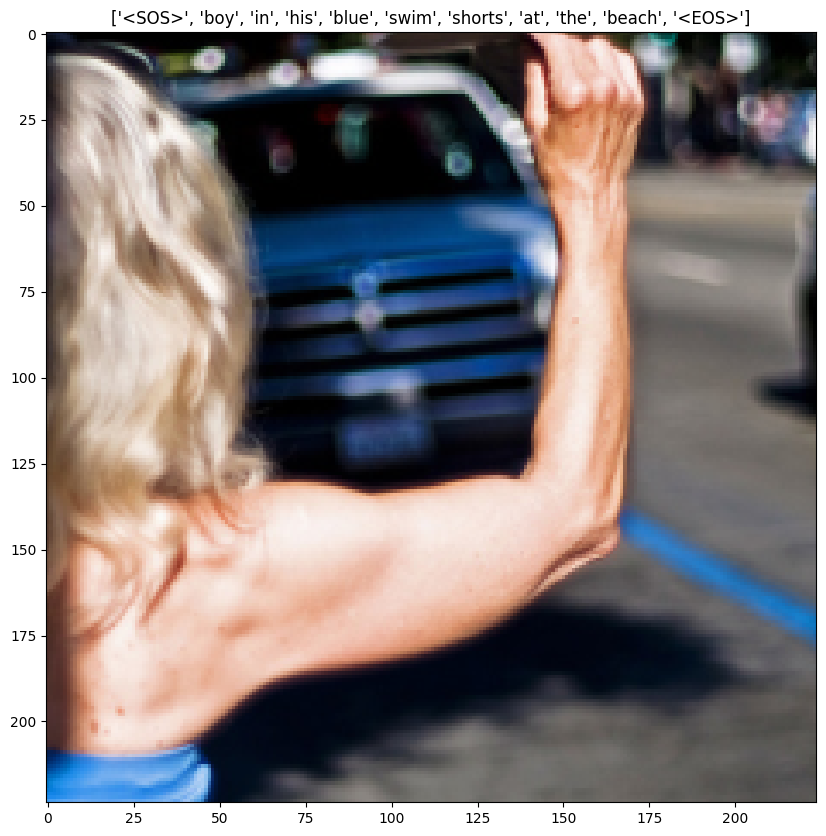

In [71]:
rcParams['figure.figsize'] = 10, 10
show_image(test_dataset[0][0], [test_dataset.vocab.itos[int(i.numpy())] for i in test_dataset[5][1]])

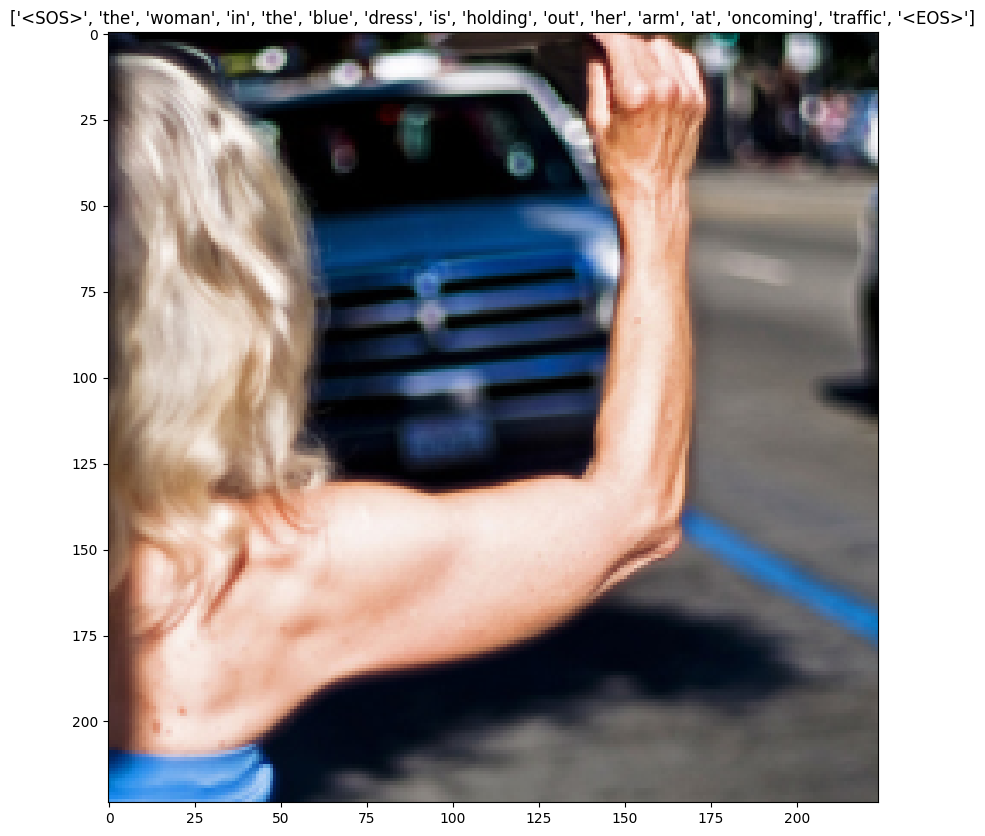

In [73]:
rcParams['figure.figsize'] = 10, 10
show_image(test_dataset[4][0], [test_dataset.vocab.itos[int(i.numpy())] for i in test_dataset[4][1]])

In [137]:
y_pred = []
y = []
with torch.no_grad():
    for idx in range(0, len(test_dataset), 5):
        features = model.encoder(test_dataset[idx][0].unsqueeze(0).to(device))
        caption, alphas = model.decoder.generate_caption(features, 40, vocab=test_dataset.vocab)
        y_pred.append(caption[0:-1])
        y_hypotheses = []
        for i in range(idx, idx + 5):
            #print(test_dataset.vocab.itos[int(j.numpy())])
            y_hypotheses.append([test_dataset.vocab.itos[int(j.numpy())] for j in test_dataset[i][1][1:-1]])
        y.append(y_hypotheses)
        if idx % 500 == 0:
            print(f"Done {idx} images")


Done 0 images
Done 500 images
Done 1000 images
Done 1500 images
Done 2000 images
Done 2500 images
Done 3000 images
Done 3500 images
Done 4000 images
Done 4500 images


In [47]:
dog_train_set = train_data[train_data["caption"].str.contains("[Dd]og")].reset_index(drop=True)
dog_test_set = test_data[test_data["caption"].str.contains("[Dd]og")].reset_index(drop=True)

dog_test_dataset = FlickrDataset("../all_images/Flicker8k_Dataset", dog_test_set, transform=toTensor, vocab=vocab)
dog_test_dataloader = DataLoader(dog_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=CapsCollate())

y_pred_dog = []
y_dog = []
with torch.no_grad():
    for idx in range(len(dog_test_set)):
        features = model.encoder(dog_test_set[idx][0].unsqueeze(0).to(device))
        caption, alphas = model.decoder.generate_caption(features, 40, vocab=test_dataset.vocab)
        y_pred.append(' '.join(caption[0:-1]))
        y.append(" ".join([test_dataset.vocab.itos[int(i.numpy())] for i in dog_test_set[idx][1]][1:-1]))
        if idx % 500 == 0:
            print(f"Done {idx} images")

KeyError: 0

In [138]:
y_pred[2]

['man',
 'in',
 'the',
 'water',
 'with',
 'his',
 'head',
 'is',
 'standing',
 'in',
 'the',
 'water',
 'with',
 'his',
 'arms',
 'out']

In [139]:
y[2]

[['lady', 'and', 'man', 'with', 'no', 'shirt', 'sit', 'on', 'dock'],
 ['man', 'and', 'woman', 'are', 'sitting', 'on', 'dock', 'together'],
 ['man', 'and', 'woman', 'sitting', 'on', 'dock'],
 ['man', 'and', 'woman', 'sitting', 'on', 'deck', 'next', 'to', 'lake'],
 ['shirtless', 'man', 'and', 'woman', 'sitting', 'on', 'dock']]

## Bleu score

- P = m / w (ratio of candidate words in the reference)
- Unigram precision = Clip(num word matches) / num words in generation
- unigram = 1-gram bleu
- bigram = 2-gram bleu
- trigram = 3-gram bleu and so on...
- from 0 to 1
- If a word is in the wrong place, the meaning changes, bleu doesn't capture this
- More focused on precision

In [146]:
# 1- gram
from nltk.translate.bleu_score import sentence_bleu
score = 0
for i in range(len(y_pred)):
    score += sentence_bleu(y[i], y_pred[i], weights=(1, 0, 0, 0))

print("average 1-gram score: ", score/len(y_pred))

average 1-gram score:  0.4459451039392218


In [147]:
# 2- gram
from nltk.translate.bleu_score import sentence_bleu
score = 0
for i in range(len(y_pred)):
    score += sentence_bleu(y[i], y_pred[i], weights=(0, 1, 0, 0))

print("average 2-gram score: ", score/len(y_pred))

average 2-gram score:  0.15844627515364892


In [148]:
# 3 - gram
from nltk.translate.bleu_score import sentence_bleu
score = 0
for i in range(len(y_pred)):
    score += sentence_bleu(y[i], y_pred[i], weights=(0, 0, 1, 0))

print("average 3-gram score: ", score/len(y_pred))

average 3-gram score:  0.04740134536842937


In [150]:
# 4 - gram
from nltk.translate.bleu_score import sentence_bleu
score = 0
for i in range(len(y_pred)):
    score += sentence_bleu(y[i], y_pred[i], weights=(0, 0, 0, 1))

print("average 4-gram score: ", score/len(y_pred))

average 4-gram score:  0.012877788321602848


In [142]:
sentence_bleu(y[0], y_pred[0])

1.154647032204335e-231

In [136]:
y_pred[0]

['white', 'dog', 'is', 'running', 'through', 'the', 'sand']

In [48]:
import spacy
nlp = spacy.load('en_core_web_sm')

similarities = 0

for i in range(len(y_pred)):
    similarities += nlp(' '.join(y_pred[i])).similarity(nlp(' '.join(y[i])))
    
print(similarities/len(y_pred))

C:\Users\bruno\AppData\Local\Temp\ipykernel_30212\745975757.py:7: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  similarities += nlp(' '.join(y_pred[i])).similarity(nlp(' '.join(y[i])))


0.5104725908156743
